# Extract MLP's matrix of weights

In [63]:
# Download all needed dependencies
# ! pip install git+https://github.com/aimclub/eXplain-NNs &> /dev/null
# ! pip install torchmetrics &> /dev/null
# ! pip install giotto-ph==0.2.2 &> /dev/null
# ! pip install giotto-tda==0.6.0 &> /dev/null
# ! pip install umap-learn==0.5.3 &> /dev/null

In [64]:
# Importing all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import eXNN.topology
import json

import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt

In [65]:
# Read preprocessed bike dataset
prep_bike_df = pd.read_csv('./prep_bike_data.csv')
prep_bike_df

,rank(season),yr,rank(mnth),rank(hr),holiday,rank(weekday),workingday,weathersit,rank(temp),rank(atemp),rank(hum),rank(windspeed),rank(casual),rank(registered),cnt
0,-1.16483,0,-1.737916,-2.035759,0,1.459083,0,1,-1.276942,-0.946560,0.770810,-1.532339,-0.774893,-1.037755,16
1,-1.16483,0,-1.737916,-1.533273,0,1.459083,0,1,-1.448913,-1.045073,0.734244,-1.532339,-0.356451,-0.699187,40
2,-1.16483,0,-1.737916,-1.259057,0,1.459083,0,1,-1.448913,-1.045073,0.734244,-1.532339,-0.564583,-0.766063,32
3,-1.16483,0,-1.737916,-1.059753,0,1.459083,0,1,-1.276942,-0.946560,0.509186,-1.532339,-0.774893,-1.126601,13
4,-1.16483,0,-1.737916,-0.897469,0,1.459083,0,1,-1.276942,-0.946560,0.509186,-1.532339,-1.690293,-2.448942,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,-1.16483,1,1.720548,0.883425,0,-0.788204,1,2,-1.117398,-1.152974,-0.121890,-0.127559,-0.204644,-0.057581,119
17375,-1.16483,1,1.720548,1.051068,0,-0.788204,1,2,-1.117398,-1.152974,-0.121890,-0.127559,-0.356451,-0.265968,89
17376,-1.16483,1,1.720548,1.255084,0,-0.788204,1,1,-1.117398,-1.152974,-0.121890,-0.127559,-0.417236,-0.250236,90
17377,-1.16483,1,1.720548,1.531407,0,-0.788204,1,1,-1.117398,-1.045073,-0.276442,-0.384024,-0.119057,-0.537970,61


In [66]:
# Create a Full-Connected Neural Network class
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(MultiLayerPerceptron, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(0.23)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(120, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Dropout(0.23)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(150, 140),
            nn.BatchNorm1d(140),
            nn.ReLU(),
            nn.Dropout(0.23)
        )

        self.layer4 = nn.Sequential(
            nn.Linear(140, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),   
            nn.Dropout(0.23)
        )

        self.layer5 = nn.Sequential(
            nn.Linear(250, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(0.23)
        )
    
        self.layer6 = nn.Sequential(
            nn.Linear(120, output_dim),
            # nn.Sigmoid()
        )

    # Define forward loop for NN
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

In [67]:
# Define function for calculation RMSE
def root_mean_squared_error(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [91]:
# Define training and evaluating steps
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs, test_data, batch, out_dir):
    home_dir = f'./bike_output/{out_dir}/weights_graphs_mlp_DataAmount{batch}/barcodes/'
    os.makedirs(home_dir)
    train_losses = list()
    test_losses = list()
    rmse_scores = list()
    bar_datum = dict()
    bar_evaluation = dict()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            all_outputs = list()
            all_targets = list()
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                all_outputs.append(outputs)
                all_targets.append(targets)

            test_loss /= len(test_loader)
            test_losses.append(test_loss)

            all_outputs = torch.cat(all_outputs, dim=0)
            all_targets = torch.cat(all_targets, dim=0)
            rmse_value = root_mean_squared_error(all_targets, all_outputs)
            rmse_scores.append(rmse_value)
        scheduler.step()

        # Applying some TDA methods to study the obtained network
        model = model.to(torch.device('cpu'))
        data = torch.stack([test_data[i][0] for i in range(100)])
        layer_list = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']
        barcodes = eXNN.topology.get_nn_barcodes(model, data, layers=layer_list, hom_type="standard", coefs_type="2")
        barcodes_data = dict()
        barcodes_eval = dict()
        epoch_dir = home_dir + f'epoch{epoch+1}/'
        os.makedirs(epoch_dir, exist_ok=True)
        for i in range(1, 7):
            barcode = barcodes[f'layer{i}']
            # Save barcodes' info into the JSON
            barcodes_data.setdefault(f'layer{i}', barcode)

            # Obtain the barcode after epoch and saving it
            bplot = eXNN.topology.plot_barcode(barcode)
            save_fig_path = epoch_dir + f'layer{i}_barcode.png'
            bplot.savefig(save_fig_path)

            # Get and save evaluation for barcode into the JSON
            bar_eval = eXNN.topology.evaluate_barcode(barcode)
            barcodes_eval.setdefault(f'layer{i}', bar_eval)

        bar_datum.setdefault(f'epoch{epoch+1}', barcodes_data)
        bar_evaluation.setdefault(f'epoch{epoch+1}', barcodes_eval)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, RMSE: {rmse_value:.4f}')

    # Save dictionaries with barcodes' data and evaluation as JSON files
    with open(f'{home_dir}barcode_data.json', 'w', encoding='utf-8') as file:
        json.dump(bar_datum, file, indent=4)
    
    with open(f'{home_dir}barcode_evaluation.json', 'w', encoding='utf-8') as json_eval:
        json.dump(bar_evaluation, json_eval, indent=4)

    # Get model's weights
    model_weights = model.state_dict()

    # Loss and MAPE visualisation
    fig = plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.plot(rmse_scores, label='RMSE')
    plt.title('Loss and RMSE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

    return fig, model_weights

In [87]:
# Define function for training network on non-full data
def batch_fit(batch_df, epochs: int, batch: int, out_dir: str):
    # Separate data into features and targets
    X = batch_df.iloc[:, :-1].values
    y = batch_df.iloc[:, -1].values
    y = y.reshape(-1, 1)

    # Data normalization
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)

    # Splitting data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=42)

    # Convertation data to PyTorch tensors
    train_features = torch.tensor(X_train, dtype=torch.float32)
    test_features = torch.tensor(X_test, dtype=torch.float32)
    train_targets = torch.tensor(y_train, dtype=torch.float32)
    test_targets = torch.tensor(y_test, dtype=torch.float32)    

    # Creating DataLoader
    train_data = TensorDataset(train_features, train_targets)
    test_data = TensorDataset(test_features, test_targets)

    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

    # Model initialization
    model = MultiLayerPerceptron(14, 1)

    # Define optimizator and loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=6.4905716870829137e-05, weight_decay=0.1)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

    # Perform training
    fig, model_weights = train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs, test_data, batch, out_dir)

    return fig, model_weights

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.3147, Test Loss: 0.1381, RMSE: 0.3717


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 2/40, Train Loss: 0.2116, Test Loss: 0.0821, RMSE: 0.2873


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 3/40, Train Loss: 0.1649, Test Loss: 0.0480, RMSE: 0.2196


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 4/40, Train Loss: 0.1280, Test Loss: 0.0334, RMSE: 0.1828


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 5/40, Train Loss: 0.1232, Test Loss: 0.0226, RMSE: 0.1507


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 6/40, Train Loss: 0.1137, Test Loss: 0.0209, RMSE: 0.1445


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 7/40, Train Loss: 0.1082, Test Loss: 0.0148, RMSE: 0.1217


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 8/40, Train Loss: 0.0981, Test Loss: 0.0159, RMSE: 0.1261


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 9/40, Train Loss: 0.0932, Test Loss: 0.0152, RMSE: 0.1233


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 10/40, Train Loss: 0.0920, Test Loss: 0.0137, RMSE: 0.1168


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 11/40, Train Loss: 0.0955, Test Loss: 0.0151, RMSE: 0.1224


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 12/40, Train Loss: 0.0845, Test Loss: 0.0135, RMSE: 0.1159


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 13/40, Train Loss: 0.0832, Test Loss: 0.0125, RMSE: 0.1115


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 14/40, Train Loss: 0.0843, Test Loss: 0.0120, RMSE: 0.1090


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 15/40, Train Loss: 0.0723, Test Loss: 0.0129, RMSE: 0.1132


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 16/40, Train Loss: 0.0776, Test Loss: 0.0116, RMSE: 0.1072


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 17/40, Train Loss: 0.0726, Test Loss: 0.0112, RMSE: 0.1055


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 18/40, Train Loss: 0.0712, Test Loss: 0.0113, RMSE: 0.1058


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 19/40, Train Loss: 0.0692, Test Loss: 0.0119, RMSE: 0.1091


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 20/40, Train Loss: 0.0661, Test Loss: 0.0116, RMSE: 0.1072


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 21/40, Train Loss: 0.0687, Test Loss: 0.0103, RMSE: 0.1007


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 22/40, Train Loss: 0.0705, Test Loss: 0.0118, RMSE: 0.1082


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 23/40, Train Loss: 0.0666, Test Loss: 0.0111, RMSE: 0.1049


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 24/40, Train Loss: 0.0630, Test Loss: 0.0106, RMSE: 0.1025


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 25/40, Train Loss: 0.0609, Test Loss: 0.0106, RMSE: 0.1023


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 26/40, Train Loss: 0.0600, Test Loss: 0.0111, RMSE: 0.1052


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 27/40, Train Loss: 0.0646, Test Loss: 0.0099, RMSE: 0.0991


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 28/40, Train Loss: 0.0627, Test Loss: 0.0105, RMSE: 0.1018


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 29/40, Train Loss: 0.0618, Test Loss: 0.0099, RMSE: 0.0988


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 30/40, Train Loss: 0.0594, Test Loss: 0.0097, RMSE: 0.0978


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 31/40, Train Loss: 0.0567, Test Loss: 0.0097, RMSE: 0.0982


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 32/40, Train Loss: 0.0556, Test Loss: 0.0097, RMSE: 0.0979


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 33/40, Train Loss: 0.0569, Test Loss: 0.0091, RMSE: 0.0950


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 34/40, Train Loss: 0.0548, Test Loss: 0.0095, RMSE: 0.0973


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 35/40, Train Loss: 0.0591, Test Loss: 0.0095, RMSE: 0.0969


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 36/40, Train Loss: 0.0536, Test Loss: 0.0091, RMSE: 0.0949


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 37/40, Train Loss: 0.0540, Test Loss: 0.0097, RMSE: 0.0978


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 38/40, Train Loss: 0.0569, Test Loss: 0.0091, RMSE: 0.0950


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 39/40, Train Loss: 0.0529, Test Loss: 0.0095, RMSE: 0.0973


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 40/40, Train Loss: 0.0516, Test Loss: 0.0091, RMSE: 0.0947


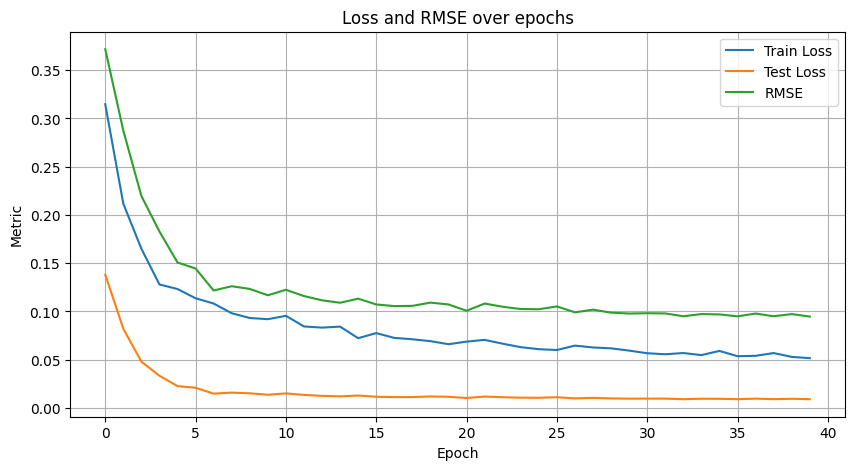

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.1862, Test Loss: 0.0301, RMSE: 0.1716


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 2/40, Train Loss: 0.1337, Test Loss: 0.0221, RMSE: 0.1475


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 3/40, Train Loss: 0.1142, Test Loss: 0.0173, RMSE: 0.1312


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 4/40, Train Loss: 0.0998, Test Loss: 0.0162, RMSE: 0.1268


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 5/40, Train Loss: 0.0920, Test Loss: 0.0146, RMSE: 0.1204


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 6/40, Train Loss: 0.0842, Test Loss: 0.0122, RMSE: 0.1097


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 7/40, Train Loss: 0.0764, Test Loss: 0.0125, RMSE: 0.1106


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 8/40, Train Loss: 0.0719, Test Loss: 0.0103, RMSE: 0.1001


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 9/40, Train Loss: 0.0669, Test Loss: 0.0094, RMSE: 0.0953


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 10/40, Train Loss: 0.0625, Test Loss: 0.0089, RMSE: 0.0933


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 11/40, Train Loss: 0.0557, Test Loss: 0.0073, RMSE: 0.0844


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 12/40, Train Loss: 0.0529, Test Loss: 0.0073, RMSE: 0.0846


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 13/40, Train Loss: 0.0528, Test Loss: 0.0066, RMSE: 0.0807


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 14/40, Train Loss: 0.0487, Test Loss: 0.0069, RMSE: 0.0823


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 15/40, Train Loss: 0.0458, Test Loss: 0.0058, RMSE: 0.0757


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 16/40, Train Loss: 0.0417, Test Loss: 0.0071, RMSE: 0.0840


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 17/40, Train Loss: 0.0398, Test Loss: 0.0079, RMSE: 0.0888


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 18/40, Train Loss: 0.0381, Test Loss: 0.0048, RMSE: 0.0690


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 19/40, Train Loss: 0.0364, Test Loss: 0.0056, RMSE: 0.0748


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 20/40, Train Loss: 0.0345, Test Loss: 0.0061, RMSE: 0.0774


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 21/40, Train Loss: 0.0318, Test Loss: 0.0069, RMSE: 0.0826


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 22/40, Train Loss: 0.0308, Test Loss: 0.0051, RMSE: 0.0715


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 23/40, Train Loss: 0.0306, Test Loss: 0.0051, RMSE: 0.0714


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 24/40, Train Loss: 0.0288, Test Loss: 0.0065, RMSE: 0.0802


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 25/40, Train Loss: 0.0257, Test Loss: 0.0049, RMSE: 0.0698


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 26/40, Train Loss: 0.0250, Test Loss: 0.0048, RMSE: 0.0687


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 27/40, Train Loss: 0.0247, Test Loss: 0.0049, RMSE: 0.0701


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 28/40, Train Loss: 0.0233, Test Loss: 0.0051, RMSE: 0.0710


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 29/40, Train Loss: 0.0233, Test Loss: 0.0043, RMSE: 0.0652


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 30/40, Train Loss: 0.0220, Test Loss: 0.0051, RMSE: 0.0705


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 31/40, Train Loss: 0.0213, Test Loss: 0.0060, RMSE: 0.0767


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 32/40, Train Loss: 0.0203, Test Loss: 0.0055, RMSE: 0.0735


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 33/40, Train Loss: 0.0196, Test Loss: 0.0052, RMSE: 0.0716


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 34/40, Train Loss: 0.0192, Test Loss: 0.0055, RMSE: 0.0735


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 35/40, Train Loss: 0.0183, Test Loss: 0.0051, RMSE: 0.0705


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 36/40, Train Loss: 0.0183, Test Loss: 0.0056, RMSE: 0.0745


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 37/40, Train Loss: 0.0176, Test Loss: 0.0060, RMSE: 0.0771


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 38/40, Train Loss: 0.0174, Test Loss: 0.0044, RMSE: 0.0660


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 39/40, Train Loss: 0.0164, Test Loss: 0.0053, RMSE: 0.0726


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 40/40, Train Loss: 0.0164, Test Loss: 0.0042, RMSE: 0.0645


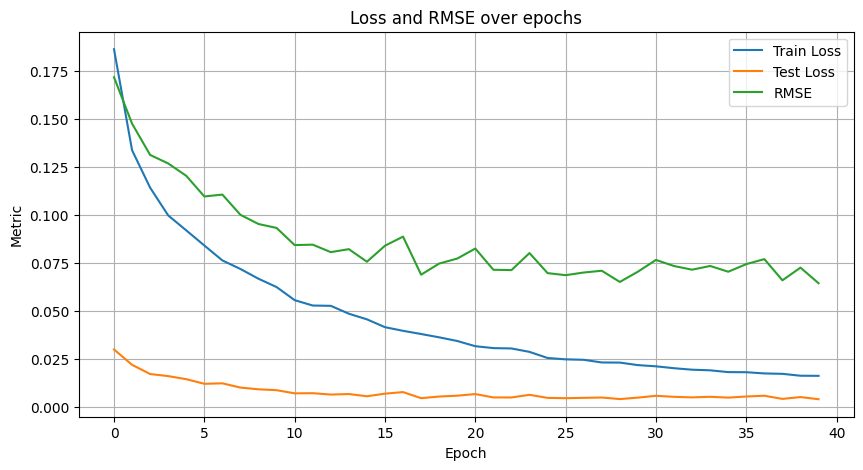

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.1704, Test Loss: 0.0313, RMSE: 0.1810


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 2/40, Train Loss: 0.1113, Test Loss: 0.0200, RMSE: 0.1452


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 3/40, Train Loss: 0.0931, Test Loss: 0.0183, RMSE: 0.1390


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 4/40, Train Loss: 0.0809, Test Loss: 0.0138, RMSE: 0.1206


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 5/40, Train Loss: 0.0707, Test Loss: 0.0125, RMSE: 0.1149


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 6/40, Train Loss: 0.0618, Test Loss: 0.0096, RMSE: 0.1006


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 7/40, Train Loss: 0.0556, Test Loss: 0.0095, RMSE: 0.1001


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 8/40, Train Loss: 0.0497, Test Loss: 0.0089, RMSE: 0.0972


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 9/40, Train Loss: 0.0461, Test Loss: 0.0073, RMSE: 0.0879


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 10/40, Train Loss: 0.0409, Test Loss: 0.0071, RMSE: 0.0856


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 11/40, Train Loss: 0.0374, Test Loss: 0.0060, RMSE: 0.0787


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 12/40, Train Loss: 0.0354, Test Loss: 0.0078, RMSE: 0.0907


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 13/40, Train Loss: 0.0315, Test Loss: 0.0074, RMSE: 0.0874


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 14/40, Train Loss: 0.0284, Test Loss: 0.0057, RMSE: 0.0774


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 15/40, Train Loss: 0.0261, Test Loss: 0.0051, RMSE: 0.0728


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 16/40, Train Loss: 0.0241, Test Loss: 0.0044, RMSE: 0.0679


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 17/40, Train Loss: 0.0231, Test Loss: 0.0054, RMSE: 0.0751


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 18/40, Train Loss: 0.0210, Test Loss: 0.0046, RMSE: 0.0695


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 19/40, Train Loss: 0.0196, Test Loss: 0.0045, RMSE: 0.0682


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 20/40, Train Loss: 0.0178, Test Loss: 0.0035, RMSE: 0.0601


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 21/40, Train Loss: 0.0172, Test Loss: 0.0042, RMSE: 0.0656


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 22/40, Train Loss: 0.0157, Test Loss: 0.0042, RMSE: 0.0664


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 23/40, Train Loss: 0.0151, Test Loss: 0.0037, RMSE: 0.0620


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 24/40, Train Loss: 0.0147, Test Loss: 0.0042, RMSE: 0.0661


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 25/40, Train Loss: 0.0136, Test Loss: 0.0028, RMSE: 0.0544


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 26/40, Train Loss: 0.0135, Test Loss: 0.0032, RMSE: 0.0579


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 27/40, Train Loss: 0.0120, Test Loss: 0.0034, RMSE: 0.0591


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 28/40, Train Loss: 0.0116, Test Loss: 0.0023, RMSE: 0.0488


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 29/40, Train Loss: 0.0116, Test Loss: 0.0032, RMSE: 0.0574


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 30/40, Train Loss: 0.0111, Test Loss: 0.0033, RMSE: 0.0580


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 31/40, Train Loss: 0.0105, Test Loss: 0.0025, RMSE: 0.0506


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 32/40, Train Loss: 0.0104, Test Loss: 0.0031, RMSE: 0.0564


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 33/40, Train Loss: 0.0101, Test Loss: 0.0021, RMSE: 0.0463


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 34/40, Train Loss: 0.0096, Test Loss: 0.0041, RMSE: 0.0646


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 35/40, Train Loss: 0.0095, Test Loss: 0.0032, RMSE: 0.0576


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 36/40, Train Loss: 0.0091, Test Loss: 0.0026, RMSE: 0.0518


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 37/40, Train Loss: 0.0089, Test Loss: 0.0048, RMSE: 0.0698


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 38/40, Train Loss: 0.0085, Test Loss: 0.0031, RMSE: 0.0569


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 39/40, Train Loss: 0.0086, Test Loss: 0.0029, RMSE: 0.0545


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 40/40, Train Loss: 0.0081, Test Loss: 0.0025, RMSE: 0.0502


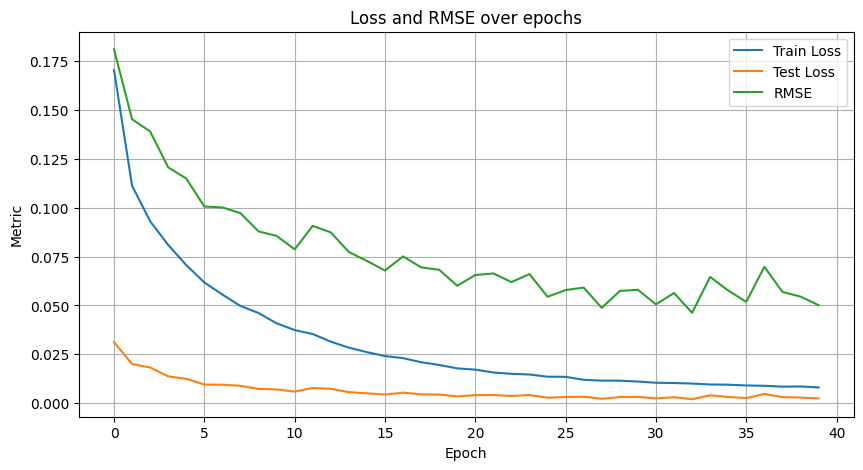

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.2545, Test Loss: 0.0243, RMSE: 0.1554


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 2/40, Train Loss: 0.1136, Test Loss: 0.0165, RMSE: 0.1279


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 3/40, Train Loss: 0.0914, Test Loss: 0.0152, RMSE: 0.1230


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 4/40, Train Loss: 0.0775, Test Loss: 0.0121, RMSE: 0.1097


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 5/40, Train Loss: 0.0686, Test Loss: 0.0128, RMSE: 0.1126


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 6/40, Train Loss: 0.0607, Test Loss: 0.0103, RMSE: 0.1011


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 7/40, Train Loss: 0.0544, Test Loss: 0.0096, RMSE: 0.0977


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 8/40, Train Loss: 0.0460, Test Loss: 0.0088, RMSE: 0.0933


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 9/40, Train Loss: 0.0403, Test Loss: 0.0077, RMSE: 0.0872


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 10/40, Train Loss: 0.0356, Test Loss: 0.0078, RMSE: 0.0880


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 11/40, Train Loss: 0.0301, Test Loss: 0.0063, RMSE: 0.0791


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 12/40, Train Loss: 0.0265, Test Loss: 0.0059, RMSE: 0.0764


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 13/40, Train Loss: 0.0237, Test Loss: 0.0046, RMSE: 0.0678


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 14/40, Train Loss: 0.0211, Test Loss: 0.0046, RMSE: 0.0674


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 15/40, Train Loss: 0.0184, Test Loss: 0.0048, RMSE: 0.0686


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 16/40, Train Loss: 0.0166, Test Loss: 0.0045, RMSE: 0.0665


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 17/40, Train Loss: 0.0147, Test Loss: 0.0040, RMSE: 0.0628


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 18/40, Train Loss: 0.0137, Test Loss: 0.0039, RMSE: 0.0625


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 19/40, Train Loss: 0.0130, Test Loss: 0.0029, RMSE: 0.0539


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 20/40, Train Loss: 0.0124, Test Loss: 0.0034, RMSE: 0.0579


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 21/40, Train Loss: 0.0111, Test Loss: 0.0029, RMSE: 0.0532


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 22/40, Train Loss: 0.0104, Test Loss: 0.0025, RMSE: 0.0498


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 23/40, Train Loss: 0.0099, Test Loss: 0.0033, RMSE: 0.0571


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 24/40, Train Loss: 0.0096, Test Loss: 0.0046, RMSE: 0.0672


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 25/40, Train Loss: 0.0091, Test Loss: 0.0031, RMSE: 0.0552


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 26/40, Train Loss: 0.0084, Test Loss: 0.0024, RMSE: 0.0491


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 27/40, Train Loss: 0.0080, Test Loss: 0.0042, RMSE: 0.0641


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 28/40, Train Loss: 0.0077, Test Loss: 0.0028, RMSE: 0.0525


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 29/40, Train Loss: 0.0073, Test Loss: 0.0013, RMSE: 0.0360


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 30/40, Train Loss: 0.0068, Test Loss: 0.0022, RMSE: 0.0468


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 31/40, Train Loss: 0.0069, Test Loss: 0.0029, RMSE: 0.0534


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 32/40, Train Loss: 0.0062, Test Loss: 0.0018, RMSE: 0.0425


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 33/40, Train Loss: 0.0062, Test Loss: 0.0033, RMSE: 0.0571


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 34/40, Train Loss: 0.0058, Test Loss: 0.0023, RMSE: 0.0475


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 35/40, Train Loss: 0.0056, Test Loss: 0.0020, RMSE: 0.0440


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 36/40, Train Loss: 0.0052, Test Loss: 0.0021, RMSE: 0.0459


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 37/40, Train Loss: 0.0050, Test Loss: 0.0012, RMSE: 0.0338


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 38/40, Train Loss: 0.0047, Test Loss: 0.0015, RMSE: 0.0385


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 39/40, Train Loss: 0.0046, Test Loss: 0.0013, RMSE: 0.0354


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 40/40, Train Loss: 0.0048, Test Loss: 0.0021, RMSE: 0.0453


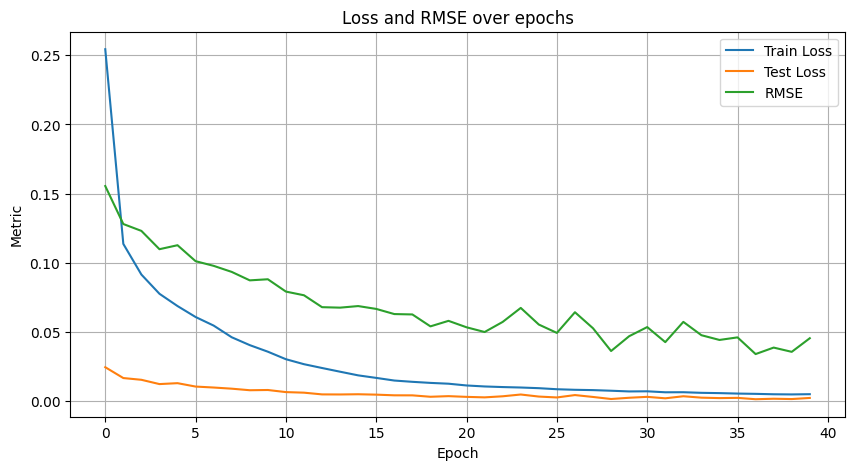

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.1302, Test Loss: 0.0200, RMSE: 0.1413


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 2/40, Train Loss: 0.0846, Test Loss: 0.0156, RMSE: 0.1244


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 3/40, Train Loss: 0.0660, Test Loss: 0.0146, RMSE: 0.1206


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 4/40, Train Loss: 0.0528, Test Loss: 0.0123, RMSE: 0.1106


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 5/40, Train Loss: 0.0438, Test Loss: 0.0096, RMSE: 0.0977


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 6/40, Train Loss: 0.0359, Test Loss: 0.0089, RMSE: 0.0942


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 7/40, Train Loss: 0.0291, Test Loss: 0.0071, RMSE: 0.0845


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 8/40, Train Loss: 0.0242, Test Loss: 0.0071, RMSE: 0.0846


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 9/40, Train Loss: 0.0197, Test Loss: 0.0081, RMSE: 0.0904


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 10/40, Train Loss: 0.0171, Test Loss: 0.0053, RMSE: 0.0734


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 11/40, Train Loss: 0.0148, Test Loss: 0.0048, RMSE: 0.0699


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 12/40, Train Loss: 0.0134, Test Loss: 0.0046, RMSE: 0.0684


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 13/40, Train Loss: 0.0116, Test Loss: 0.0038, RMSE: 0.0614


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 14/40, Train Loss: 0.0106, Test Loss: 0.0023, RMSE: 0.0482


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 15/40, Train Loss: 0.0097, Test Loss: 0.0028, RMSE: 0.0527


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 16/40, Train Loss: 0.0092, Test Loss: 0.0028, RMSE: 0.0530


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 17/40, Train Loss: 0.0082, Test Loss: 0.0029, RMSE: 0.0542


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 18/40, Train Loss: 0.0076, Test Loss: 0.0037, RMSE: 0.0606


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 19/40, Train Loss: 0.0074, Test Loss: 0.0023, RMSE: 0.0481


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 20/40, Train Loss: 0.0068, Test Loss: 0.0028, RMSE: 0.0527


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 21/40, Train Loss: 0.0064, Test Loss: 0.0019, RMSE: 0.0431


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 22/40, Train Loss: 0.0057, Test Loss: 0.0024, RMSE: 0.0492


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 23/40, Train Loss: 0.0057, Test Loss: 0.0021, RMSE: 0.0460


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 24/40, Train Loss: 0.0058, Test Loss: 0.0015, RMSE: 0.0385


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 25/40, Train Loss: 0.0053, Test Loss: 0.0023, RMSE: 0.0473


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 26/40, Train Loss: 0.0053, Test Loss: 0.0015, RMSE: 0.0385


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 27/40, Train Loss: 0.0050, Test Loss: 0.0014, RMSE: 0.0377


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 28/40, Train Loss: 0.0044, Test Loss: 0.0018, RMSE: 0.0422


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 29/40, Train Loss: 0.0042, Test Loss: 0.0015, RMSE: 0.0386


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 30/40, Train Loss: 0.0043, Test Loss: 0.0020, RMSE: 0.0445


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 31/40, Train Loss: 0.0041, Test Loss: 0.0026, RMSE: 0.0507


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 32/40, Train Loss: 0.0038, Test Loss: 0.0024, RMSE: 0.0488


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 33/40, Train Loss: 0.0038, Test Loss: 0.0025, RMSE: 0.0504


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 34/40, Train Loss: 0.0036, Test Loss: 0.0016, RMSE: 0.0401


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 35/40, Train Loss: 0.0037, Test Loss: 0.0021, RMSE: 0.0463


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 36/40, Train Loss: 0.0032, Test Loss: 0.0013, RMSE: 0.0367


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 37/40, Train Loss: 0.0031, Test Loss: 0.0024, RMSE: 0.0485


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 38/40, Train Loss: 0.0030, Test Loss: 0.0018, RMSE: 0.0425


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 39/40, Train Loss: 0.0029, Test Loss: 0.0031, RMSE: 0.0553


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 40/40, Train Loss: 0.0031, Test Loss: 0.0032, RMSE: 0.0571


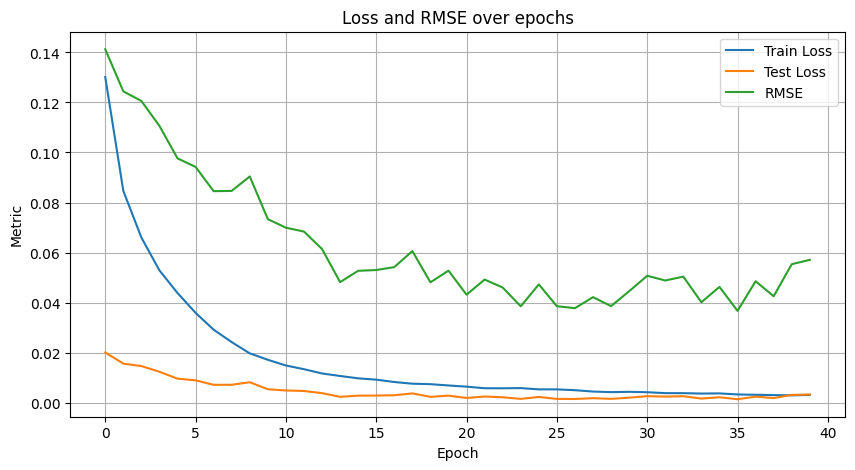

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 1/40, Train Loss: 0.1164, Test Loss: 0.0229, RMSE: 0.1524


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 2/40, Train Loss: 0.0758, Test Loss: 0.0158, RMSE: 0.1271


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 3/40, Train Loss: 0.0571, Test Loss: 0.0123, RMSE: 0.1124


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 4/40, Train Loss: 0.0468, Test Loss: 0.0104, RMSE: 0.1033


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 5/40, Train Loss: 0.0369, Test Loss: 0.0083, RMSE: 0.0920


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 6/40, Train Loss: 0.0297, Test Loss: 0.0065, RMSE: 0.0816


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 7/40, Train Loss: 0.0241, Test Loss: 0.0063, RMSE: 0.0808


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 8/40, Train Loss: 0.0187, Test Loss: 0.0052, RMSE: 0.0733


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 9/40, Train Loss: 0.0150, Test Loss: 0.0042, RMSE: 0.0656


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 10/40, Train Loss: 0.0122, Test Loss: 0.0044, RMSE: 0.0676


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 11/40, Train Loss: 0.0107, Test Loss: 0.0037, RMSE: 0.0611


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 12/40, Train Loss: 0.0097, Test Loss: 0.0028, RMSE: 0.0532


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 13/40, Train Loss: 0.0086, Test Loss: 0.0031, RMSE: 0.0565


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 14/40, Train Loss: 0.0081, Test Loss: 0.0044, RMSE: 0.0672


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 15/40, Train Loss: 0.0073, Test Loss: 0.0028, RMSE: 0.0529


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 16/40, Train Loss: 0.0069, Test Loss: 0.0019, RMSE: 0.0436


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 17/40, Train Loss: 0.0064, Test Loss: 0.0011, RMSE: 0.0340


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 18/40, Train Loss: 0.0059, Test Loss: 0.0025, RMSE: 0.0505


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 19/40, Train Loss: 0.0053, Test Loss: 0.0012, RMSE: 0.0344


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 20/40, Train Loss: 0.0050, Test Loss: 0.0009, RMSE: 0.0294


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 21/40, Train Loss: 0.0048, Test Loss: 0.0013, RMSE: 0.0358


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 22/40, Train Loss: 0.0044, Test Loss: 0.0009, RMSE: 0.0297


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 23/40, Train Loss: 0.0041, Test Loss: 0.0011, RMSE: 0.0328


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 24/40, Train Loss: 0.0041, Test Loss: 0.0017, RMSE: 0.0412


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 25/40, Train Loss: 0.0037, Test Loss: 0.0009, RMSE: 0.0297


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 26/40, Train Loss: 0.0039, Test Loss: 0.0011, RMSE: 0.0341


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 27/40, Train Loss: 0.0035, Test Loss: 0.0019, RMSE: 0.0437


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 28/40, Train Loss: 0.0034, Test Loss: 0.0020, RMSE: 0.0449


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 29/40, Train Loss: 0.0033, Test Loss: 0.0009, RMSE: 0.0299


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 30/40, Train Loss: 0.0033, Test Loss: 0.0015, RMSE: 0.0391


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 31/40, Train Loss: 0.0031, Test Loss: 0.0019, RMSE: 0.0437


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 32/40, Train Loss: 0.0031, Test Loss: 0.0018, RMSE: 0.0430


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 33/40, Train Loss: 0.0029, Test Loss: 0.0020, RMSE: 0.0452


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 34/40, Train Loss: 0.0027, Test Loss: 0.0011, RMSE: 0.0338


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 35/40, Train Loss: 0.0025, Test Loss: 0.0015, RMSE: 0.0388


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 36/40, Train Loss: 0.0026, Test Loss: 0.0012, RMSE: 0.0347


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 37/40, Train Loss: 0.0026, Test Loss: 0.0014, RMSE: 0.0380


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 38/40, Train Loss: 0.0026, Test Loss: 0.0013, RMSE: 0.0367


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 39/40, Train Loss: 0.0023, Test Loss: 0.0018, RMSE: 0.0428


/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/pavel/miniconda3/lib/python3.11/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in scalar divide



Epoch 40/40, Train Loss: 0.0024, Test Loss: 0.0009, RMSE: 0.0302


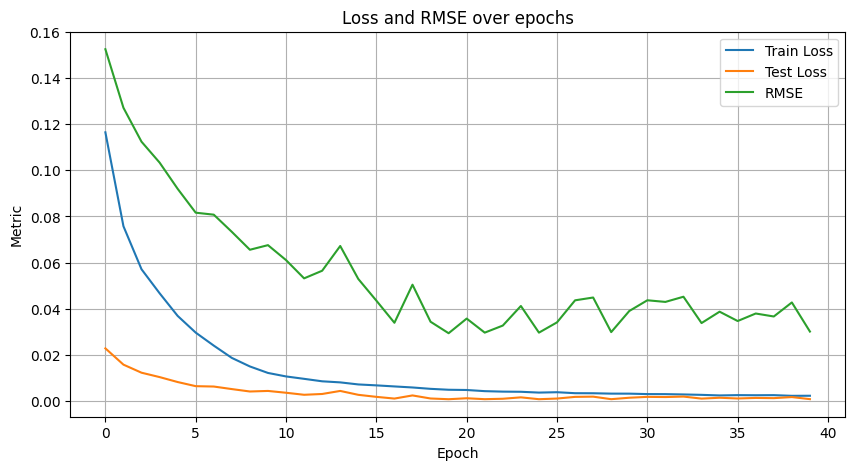

In [98]:
# Create a name for output folder
out_dir = 'exp_1'

# Create cycle for training network with different amounts of data
for batch in range(3000, len(prep_bike_df), 3000):
    base_dir = f'./bike_output/{out_dir}/weights_graphs_mlp_DataAmount{batch}/'
    # Getting part of the dataset
    df_batch = prep_bike_df.head(batch)

    # Training model and getting it's weights
    fig, model_weights = batch_fit(df_batch, 40, batch, out_dir)

    # Saving weights, loss function and RMSE
    torch.save(model_weights, f'{base_dir}weights_mlp_DataAmount{batch}.pth')
    fig.savefig(f'{base_dir}loss_and_rmse_mlp_DataAmount{batch}.png', dpi=300, bbox_inches='tight')
    

# Getting part of the dataset
df_batch = prep_bike_df.head(len(prep_bike_df))
last_dir = f'./bike_output/{out_dir}/weights_graphs_mlp_DataAmount{len(prep_bike_df)}/'

# Training model and getting it's weights
fig, model_weights = batch_fit(df_batch, 40, len(prep_bike_df), out_dir)

# Saving weights and losses
torch.save(model_weights, f'{last_dir}weights_mlp_DataAmount{len(prep_bike_df)}.pth')
fig.savefig(f'{last_dir}loss_and_rmse_mlp_DataAmount{len(prep_bike_df)}.png', dpi=300, bbox_inches='tight')